## Biodiversity of Endangered Species in National Parks

#### Introduction:

- Describe the data set and prior cleaning, including modes/averages/histograms, counts of species within categories,
- Describe analysis and conclusions. 
- Focus on most interesting conclusion/finding

In [37]:
#import py libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
#set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [19]:
biodiv = pd.read_csv("biodiversity_data.csv")
print(biodiv.columns)
print(biodiv.info())
print(biodiv.describe(include='all'))
print(biodiv.head())

Index(['scientific_name', 'park_name', 'observations', 'category', 'conservation_status', 'common_names'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22164 entries, 0 to 22163
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      22164 non-null  object
 1   park_name            22164 non-null  object
 2   observations         22164 non-null  int64 
 3   category             22164 non-null  object
 4   conservation_status  22164 non-null  object
 5   common_names         22164 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.0+ MB
None
       scientific_name park_name  observations        category conservation_status        common_names
count            22164     22164  22164.000000           22164               22164               22164
unique            5541         4           NaN               7                   5                5236
top      Abie

- Identifiers: scientific name, common names
- Categorical variables: park_name, category, conservation status
- Quatitative variables: observations


Since all species apart from those in the 'Least concern' conservation status are in a protected group, we can create a new column protection_listing that is binomial for the 'conservation_status' variable where 0 is 'Least Concern', and all other values are 1, ('Species of Concern', 'Threatened', 'Endangered', 'In Recovery')

In [20]:
#the protection listing of a species can be thought of as an binomial variable where species of Least Concern: 0 and protection listed classes: 1. 
protected_class = {'Least Concern': 0, 'Species of Concern': 1, 'In Recovery': 1, 'Threatened':1, 'Endangered':1}
biodiv['protection_listing'] = biodiv['conservation_status'].apply(lambda x: protected_class.get(x))
print(biodiv.describe())

       observations  protection_listing
count  22164.000000        22164.000000
mean     149.450866            0.032305
std       81.206840            0.176812
min        9.000000            0.000000
25%       88.000000            0.000000
50%      129.000000            0.000000
75%      217.000000            0.000000
max      805.000000            1.000000


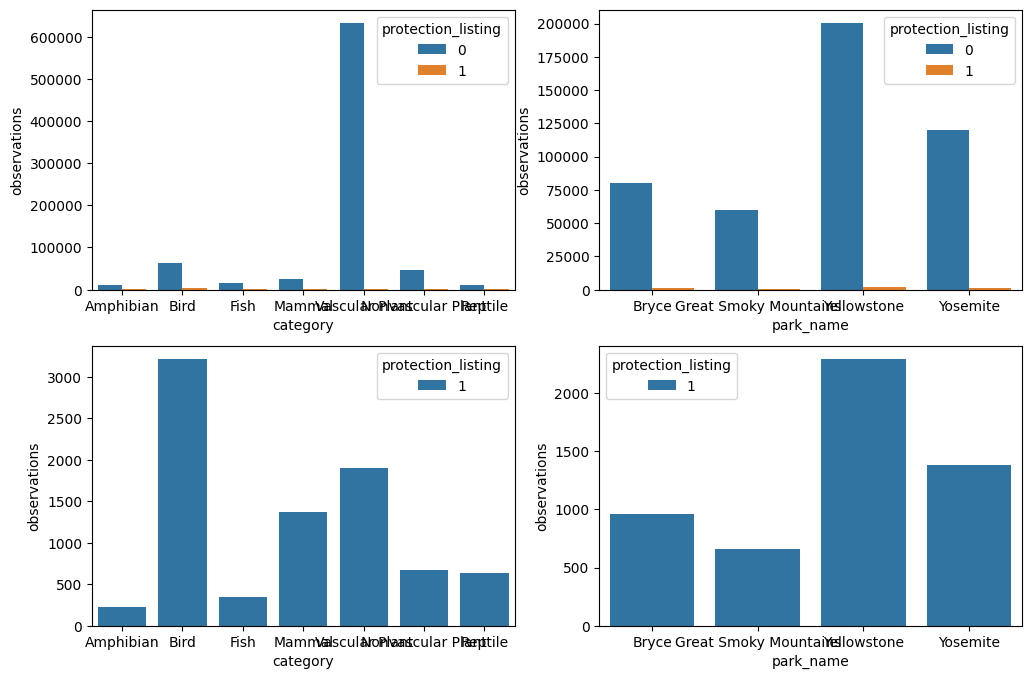

In [21]:
#The vast majority of items have in both data sets are those with a conservation status of 'No Status'. To gain visibility we can drop those.
biodiv_grouped = biodiv.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()
biodiv_protected = biodiv.drop(biodiv[biodiv['protection_listing']==0].index)
biodiv_stat_grouped = biodiv_protected.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.barplot(x='category', y= 'observations', hue='protection_listing', data=biodiv_grouped, errorbar=None)
plt.subplot(2,2,2)
sns.barplot(x='park_name', y= 'observations', hue='protection_listing', data=biodiv_grouped, errorbar = None)

plt.subplot(2,2,3)
sns.barplot(x='category', y= 'observations', hue='protection_listing', data=biodiv_grouped[biodiv_grouped['protection_listing']==1], errorbar = None)
plt.subplot(2,2,4)
sns.barplot(x='park_name', y= 'observations', hue='protection_listing', data=biodiv_grouped[biodiv_grouped['protection_listing']==1], errorbar = None)
plt.show()
plt.close('all')


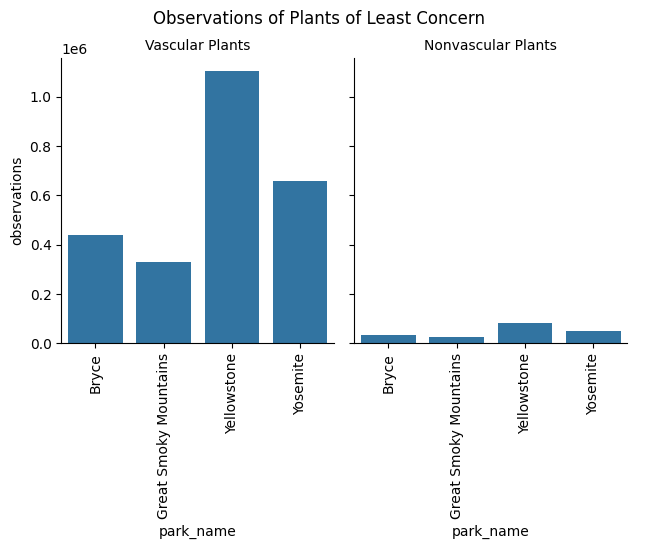

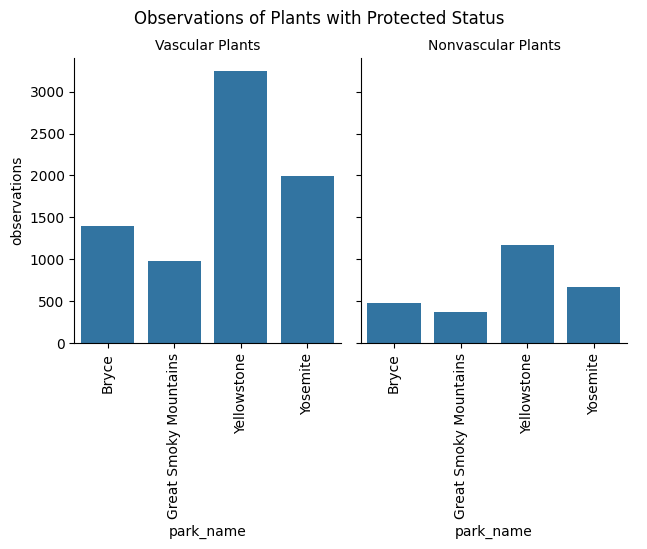

In [22]:
#For greater visibility into the protection status of relative groups of species and plants we can split into two dataframes, one for plants and one for animals.
#plants
biodiv_plants = biodiv[biodiv['category'].str.contains('Plant')].reset_index(drop=True)
biodiv_plants_gp_status= biodiv_plants.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

g=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
)
h=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8
)
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}s")
g.fig.subplots_adjust(top=.86)
g.fig.suptitle('Observations of Plants of Least Concern')
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.fig.subplots_adjust(top=.86)
h.fig.suptitle('Observations of Plants with Protected Status')
plt.show()
plt.close("all")

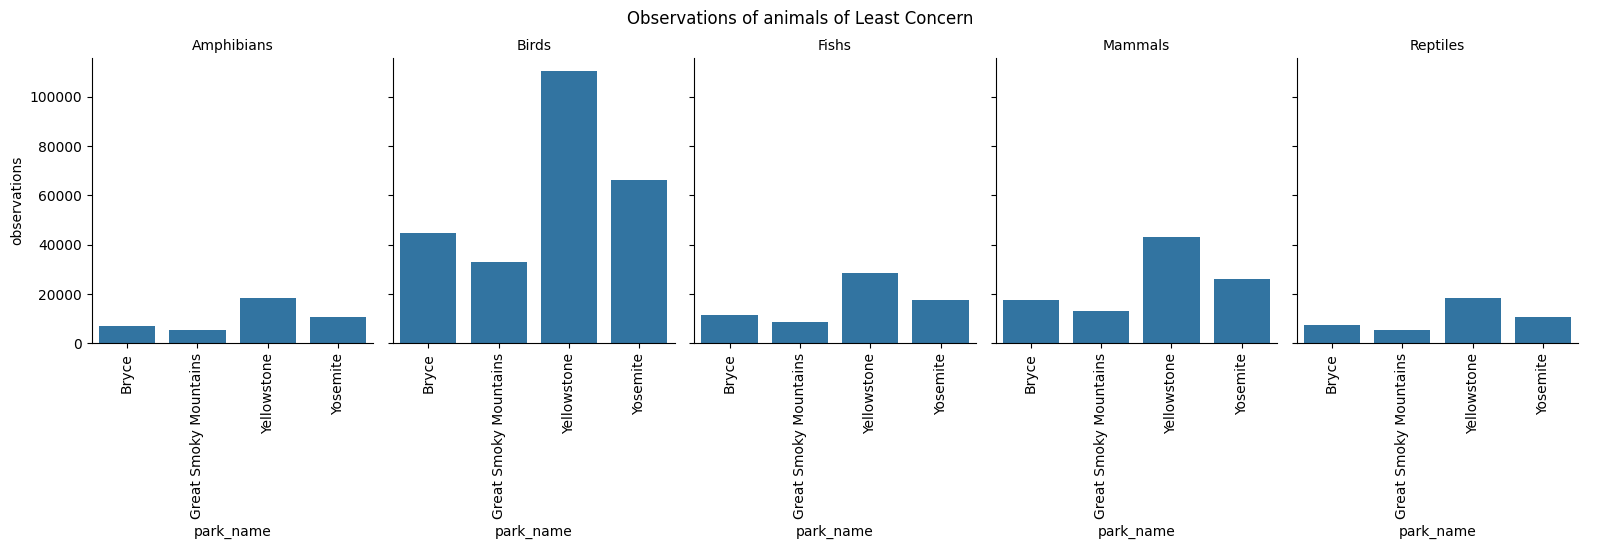

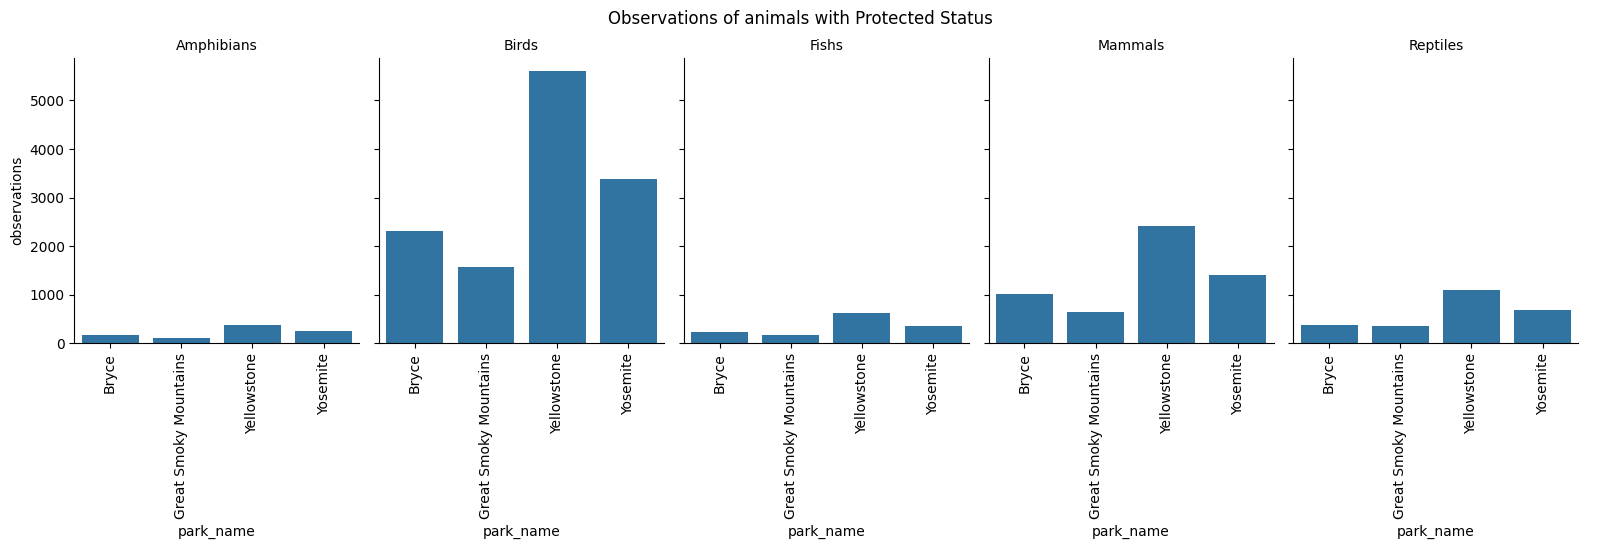

In [23]:
#For greater visibility into the protection status of relative groups of species and animals we can split into two dataframes, one for animals and one for animals.
#animals
biodiv_animals = biodiv[biodiv['category'].str.contains('Plant')==False].reset_index(drop=True)
biodiv_animals_gp_status= biodiv_animals.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()
category_order = list(biodiv_animals_gp_status.category.unique())
g=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
)
h=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8
)
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}s")
g.fig.subplots_adjust(top=.86)
g.fig.suptitle('Observations of animals of Least Concern')
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.fig.subplots_adjust(top=.86)
h.fig.suptitle('Observations of animals with Protected Status')
plt.show()
plt.close("all")

We can see from these graphs that across the board Yellowstone records the highest average observation counts across all conservation status, which stands to reason given their relative sizes.  
Yellowstone = 2,221,766 acres
Yosemite = 747,956 acres
Great Smoky Mountains = 533,427 acres
Bryce = 35,835 acres


In [24]:
#adding a column for park size
size_acres = {'Bryce': 35835, 'Great Smoky Mountains': 533427, 'Yosemite': 747956, 'Yellowstone':2221766}
biodiv['acres'] = biodiv['park_name'].apply(lambda x: size_acres.get(x))
print(biodiv.describe())
print('The average park size is '+str(biodiv.acres.mean())+' acres')
factor_acre= {}
for park, parksize in size_acres.items():
    print(str(park)+' has a size factor of x times the mean where x is: ')
    size_factor = round(parksize/(biodiv.acres.mean()),2)
    print(size_factor)
    factor_acre[park]=size_factor
biodiv['factor'] = biodiv['park_name'].apply(lambda x: factor_acre.get(x))
print(biodiv.describe())

       observations  protection_listing         acres
count  22164.000000        22164.000000  2.216400e+04
mean     149.450866            0.032305  8.847460e+05
std       81.206840            0.176812  8.140222e+05
min        9.000000            0.000000  3.583500e+04
25%       88.000000            0.000000  4.090290e+05
50%      129.000000            0.000000  6.406915e+05
75%      217.000000            0.000000  1.116408e+06
max      805.000000            1.000000  2.221766e+06
The average park size is 884746.0 acres
Bryce has a size factor of x times the mean where x is: 
0.04
Great Smoky Mountains has a size factor of x times the mean where x is: 
0.6
Yosemite has a size factor of x times the mean where x is: 
0.85
Yellowstone has a size factor of x times the mean where x is: 
2.51
       observations  protection_listing         acres        factor
count  22164.000000        22164.000000  2.216400e+04  22164.000000
mean     149.450866            0.032305  8.847460e+05      1.00000

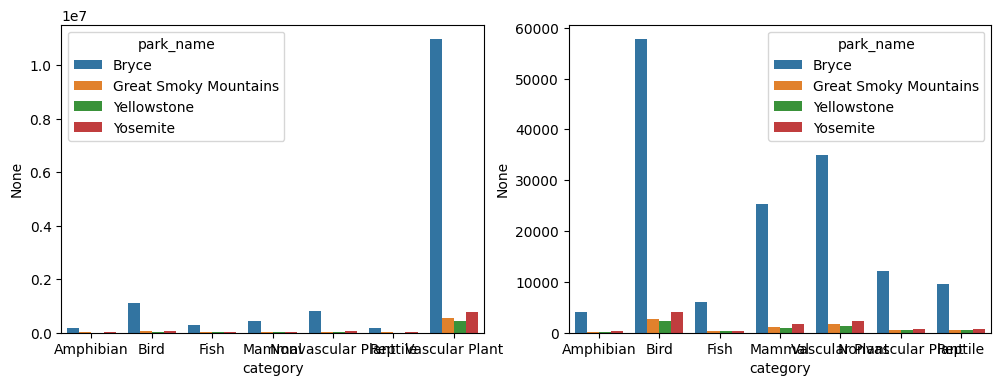

<Figure size 640x480 with 0 Axes>

In [25]:
biodiv_status_f = biodiv.drop(biodiv[biodiv['conservation_status']=='No Status'].index)
biodiv_stat_grouped_f = biodiv_status_f.groupby(['conservation_status', 'protection_listing', 'category', 'park_name', 'factor'], as_index=False)["observations"].sum()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='category', y= (biodiv_stat_grouped_f['observations']/biodiv_stat_grouped_f['factor']), hue='park_name', data=biodiv_stat_grouped_f[biodiv_stat_grouped_f['protection_listing']==0], errorbar= None)
plt.subplot(1,2,2)
sns.barplot(x='category', y= (biodiv_stat_grouped_f['observations']/biodiv_stat_grouped_f['factor']), hue='park_name', data=biodiv_stat_grouped_f[biodiv_stat_grouped_f['protection_listing']==1], errorbar= None)
plt.show()
plt.clf()

#### Analysis:

1) Is species category is correlated with it's conservation status?
2) Is National park correlated with observations counts or conservation status?
3) How are conservations status and observations correlated?

### Is species category correlated with conservation status?
- Method:
    - Group by species (scientific name) to meet independence of observation needed for Chi2
    - Split species into plant and animals for greater clarity.
    - Expected Contingency Tables for
    - Chi Squared
    - Cramér's V
- Analysis:
    - Discuss issue of 0's values in contingency table - to be a good candidate for Chi Squared analysis there should be fewer than 20% 0's in the table, though with a large dataset with strong tendencies we may find more. 
    - Plants show low Chi-squared with p-value of 0.8 -- Plants categories are likely not correlated with conservation status. ie, you're no more likely to see a Non-vascular than a Vascular plant with any particular conservation status. 
    - Animal categories vs conservation status show a high Chi-squared statistic (43.07), and low P-value (0.0003) indicating a statistically significant correlation between animal category and conservation status. 
    - Applying Cramér's V to the animal contingency and Chi2 shows a moderate, statistically significant, relationship across several variables, including Amphibian and Reptile and to a lesser degree, Fish. 
- Conclusion:
    There is some relationship between animal category and conservation status that is likely influenced by other variables. 

In [26]:
biodiv_species = biodiv.groupby(['scientific_name', 'category', 'conservation_status'], as_index=False)['observations'].sum()
status_category_contingency = pd.crosstab(biodiv_species['conservation_status'],biodiv_species['category'])
print(f"Contingency table for Conservation Status vs Category:\n{status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(status_category_contingency)
print(f"Chi-square Statistic - for plant and animal categories: {chi2}")
print(f"P-value - for plant and animal categories: {pval}")
print(f"Degrees of Freedom - for plant and animal categories: {dof}")

Contingency table for Conservation Status vs Category:
category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
conservation_status                                                                           
Endangered                   1     4     3       6                  0        0               1
In Recovery                  0     3     0       0                  0        0               0
Least Concern               72   413   114     146                328       73            4216
Species of Concern           4    68     4      22                  5        5              43
Threatened                   2     0     4       2                  0        0               2
Chi-square Statistic - for plant and animal categories: 591.1513416161314
P-value - for plant and animal categories: 1.6816257270187694e-109
Degrees of Freedom - for plant and animal categories: 24


In [27]:
#Calculate Cramér's V 
n = np.sum(status_category_contingency)
r,k = status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*min(k-1,r-1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: category
Amphibian            1.367747
Bird                 0.550313
Fish                 1.087337
Mammal               0.916353
Nonvascular Plant    0.666189
Reptile              1.376487
Vascular Plant       0.186214
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [28]:
biodiv_plant_species = biodiv_species[biodiv_species['category'].isin(['Nonvascular Plant', 'Vascular Plant'])]
biodiv_animal_species = biodiv_species[biodiv_species['category'].isin(['Bird', 'Amphibian', 'Reptile', 'Mammal', 'Fish'])]

In [29]:
plant_status_category_contingency = pd.crosstab(biodiv_plant_species['conservation_status'],biodiv_plant_species['category'])
print(f"Contingency table for Conservation Status vs Category - for Plants:\n{plant_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(plant_status_category_contingency)
print(f"Chi-square Statistic - for Plants: {chi2}")
print(f"P-value - for Plants: {pval}")
print(f"Degrees of Freedom - for Plants: {dof}")

Contingency table for Conservation Status vs Category - for Plants:
category             Nonvascular Plant  Vascular Plant
conservation_status                                   
Endangered                           0               1
Least Concern                      328            4216
Species of Concern                   5              43
Threatened                           0               2
Chi-square Statistic - for Plants: 0.9573945907675938
P-value - for Plants: 0.8115596253037896
Degrees of Freedom - for Plants: 3


In [30]:
animal_status_category_contingency = pd.crosstab(biodiv_animal_species['conservation_status'],biodiv_animal_species['category'])
print(f"Contingency table for Conservation Status vs Category - for animals:\n{animal_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(animal_status_category_contingency)
print(f"Chi-square Statistic - for animals: {chi2}")
print(f"P-value - for animals: {pval}")
print(f"Degrees of Freedom - for animals: {dof}")

Contingency table for Conservation Status vs Category - for animals:
category             Amphibian  Bird  Fish  Mammal  Reptile
conservation_status                                        
Endangered                   1     4     3       6        0
In Recovery                  0     3     0       0        0
Least Concern               72   413   114     146       73
Species of Concern           4    68     4      22        5
Threatened                   2     0     4       2        0
Chi-square Statistic - for animals: 43.0693765443132
P-value - for animals: 0.00027280616529364596
Degrees of Freedom - for animals: 16


In [31]:
#Calculate Cramér's V 
n = np.sum(animal_status_category_contingency)
r,k = animal_status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*min(k-1,r-1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: category
Amphibian    0.369182
Bird         0.148540
Fish         0.293494
Mammal       0.247342
Reptile      0.371541
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Is National park correlated with observations counts?
- Method:
    - Assess Central Tendency
    - ANOVA
    - Tukey HSD
    
- Analysis:
- Conclusion:

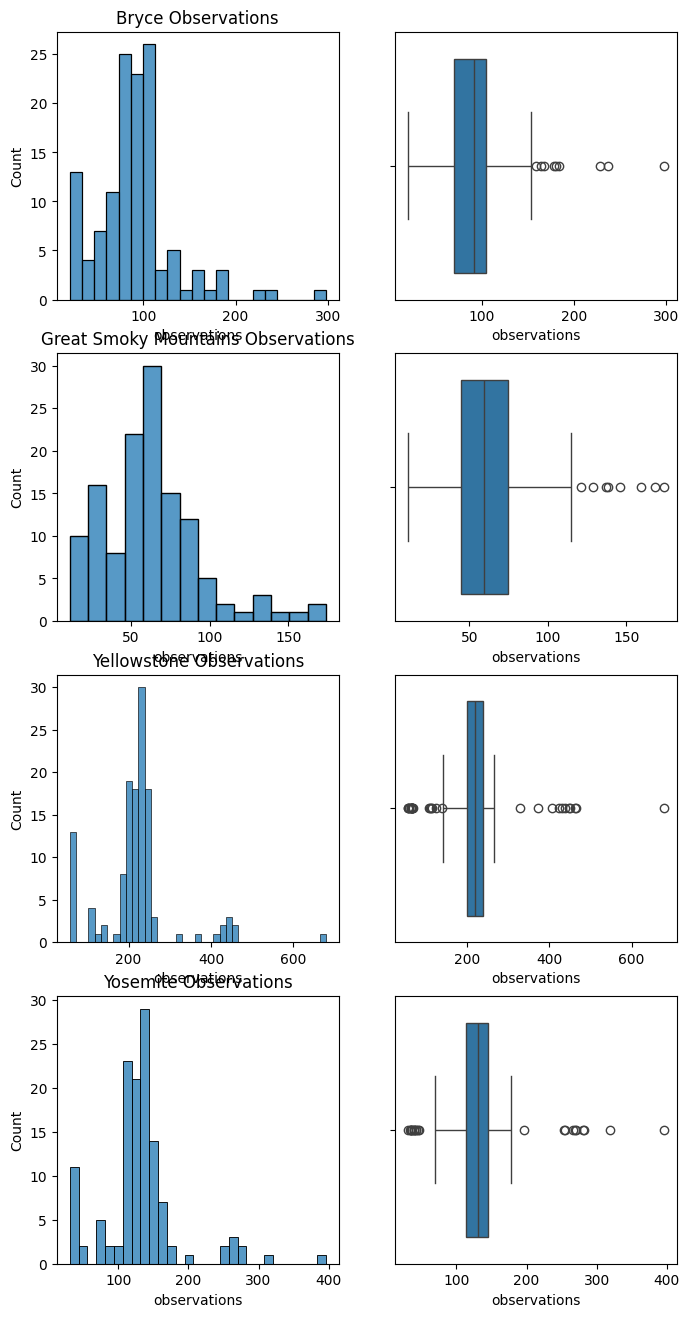

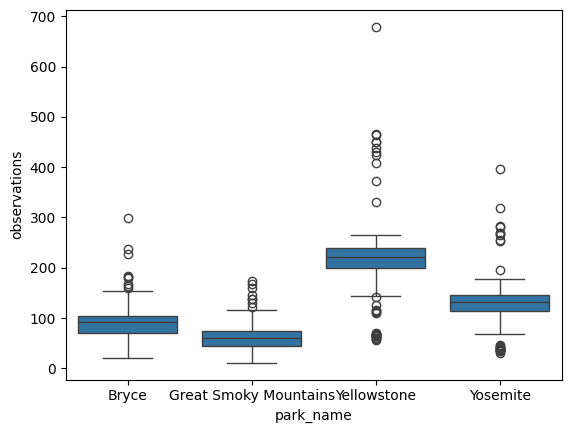

            Bryce  Great Smoky Mountains  Yellowstone    Yosemite
count  128.000000             128.000000   128.000000  128.000000
mean    90.460938              62.140625   219.921875  131.804688
std     42.639655              31.534941    91.366926   56.364402
min     20.000000              11.000000    57.000000   31.000000
25%     70.500000              44.500000   199.750000  113.500000
50%     92.000000              59.500000   221.000000  131.000000
75%    104.250000              75.000000   238.500000  145.250000
max    298.000000             174.000000   679.000000  396.000000


In [40]:
biodiv_conservation_animals = biodiv_animals[biodiv_animals['protection_listing']==1]
parks = list(biodiv['park_name'].unique())
num = 1
plt.figure(figsize=(8,16))
park_describe = {}
for park in parks:
    park_biodiv = biodiv_conservation_animals[biodiv_conservation_animals['park_name']==park]
    park_mean = park_biodiv['observations'].describe(include=all)
    park_describe[park]= park_mean
    plt.subplot(4,2,num)
    sns.histplot(park_biodiv['observations'])
    plt.title(park + ' Observations')
    num +=1
    plt.subplot(4,2,num)
    sns.boxplot(x='observations', data=park_biodiv)
    num +=1
plt.show()
plt.close('all')
sns.boxplot(data=biodiv_conservation_animals, x='park_name', y='observations')
plt.show()
plt.close('all')
parks_describe_df = pd.DataFrame(park_describe)
print(parks_describe_df)

ANOVA F and p value: 
                  sum_sq     df           F        PR(>F)
park_name  1.817092e+06    3.0  168.983233  5.729259e-76
Residual   1.820857e+06  508.0         NaN           NaN
Model Results Summary: 
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     169.0
Date:                Sun, 25 Feb 2024   Prob (F-statistic):           5.73e-76
Time:                        16:46:43   Log-Likelihood:                -2819.7
No. Observations:                 512   AIC:                             5647.
Df Residuals:                     508   BIC:                             5664.
Df Model:                           3                                         
Covariance Type:            nonrobust                                  

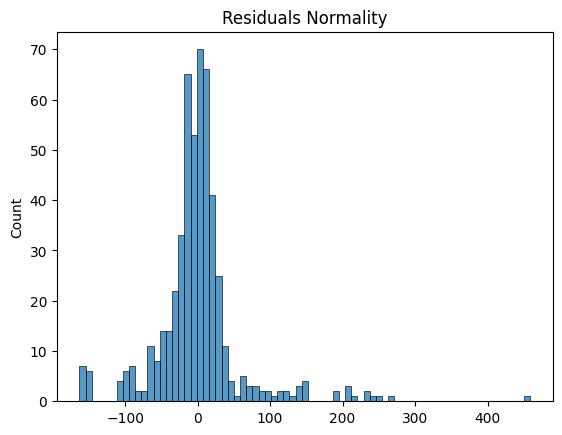

<Figure size 640x480 with 0 Axes>

In [35]:
#ANOVA using OLS- Ordinary Least Squares
model = sm.OLS.from_formula('observations~park_name', biodiv_conservation_animals)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)
print(f"ANOVA F and p value: \n {anova_table}")
print(f"Model Results Summary: \n{results.summary()}")
residuals = biodiv_conservation_animals.observations-results.predict(biodiv_conservation_animals)
plt.figure()
sns.histplot(residuals)
plt.title("Residuals Normality")
plt.show()
plt.clf()


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
                Bryce Great Smoky Mountains -28.3203 0.001  -47.6099  -9.0307   True
                Bryce           Yellowstone 129.4609   0.0  110.1713 148.7506   True
                Bryce              Yosemite  41.3438   0.0   22.0541  60.6334   True
Great Smoky Mountains           Yellowstone 157.7812   0.0  138.4916 177.0709   True
Great Smoky Mountains              Yosemite  69.6641   0.0   50.3744  88.9537   True
          Yellowstone              Yosemite -88.1172   0.0 -107.4068 -68.8276   True
------------------------------------------------------------------------------------


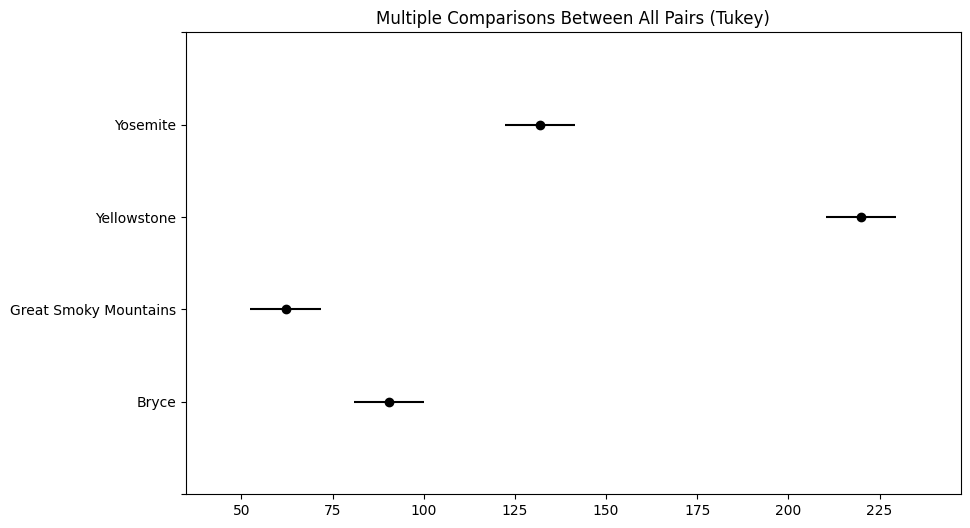

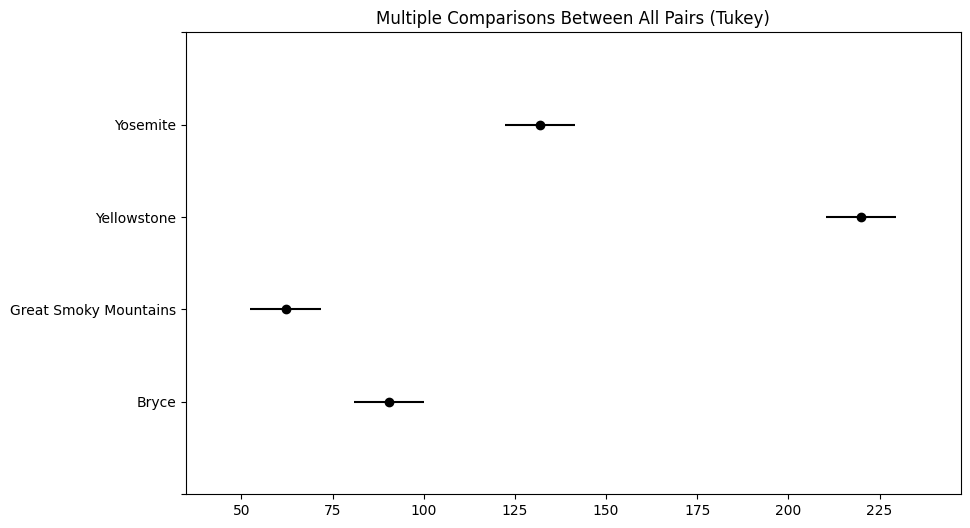

In [39]:
tukey_results = pairwise_tukeyhsd(endog=biodiv_conservation_animals['observations'], groups=biodiv_conservation_animals['park_name'], alpha=0.05)

# Print the results
print(tukey_results)
tukey_results.plot_simultaneous()

Since there is a correlation between conservation status and category and between park and observations. Let's see if there is an interaction between park and category with respect to their impact on observations.
- Method:
    1) 2-Way Anova
- Analysis:
- Conclusion: Park and Category are both independently correlated to observations in this data set, but they do not interact. 

In [42]:
model2 = sm.OLS.from_formula('observations~C(park_name)*C(category)', biodiv_conservation_animals)
results2 = model2.fit()
anova_table_2way = sm.stats.anova_lm(results2, typ=2)

print(anova_table_2way)

                                sum_sq     df           F        PR(>F)
C(park_name)              1.817092e+06    3.0  173.195143  1.251772e-76
C(category)               7.891564e+04    4.0    5.641352  1.907517e-04
C(park_name):C(category)  2.132067e+04   12.0    0.508042  9.098909e-01
Residual                  1.720620e+06  492.0         NaN           NaN


How are conservations status and observations correlated?
- Method:
- Analysis:
- Conclusion:

  conservation_status  observations
0          Endangered     47.071429
1         In Recovery    116.000000
2  Species of Concern    140.143204
3          Threatened     87.093750


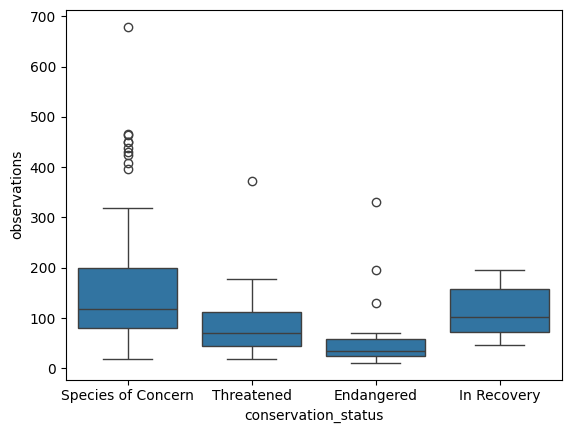

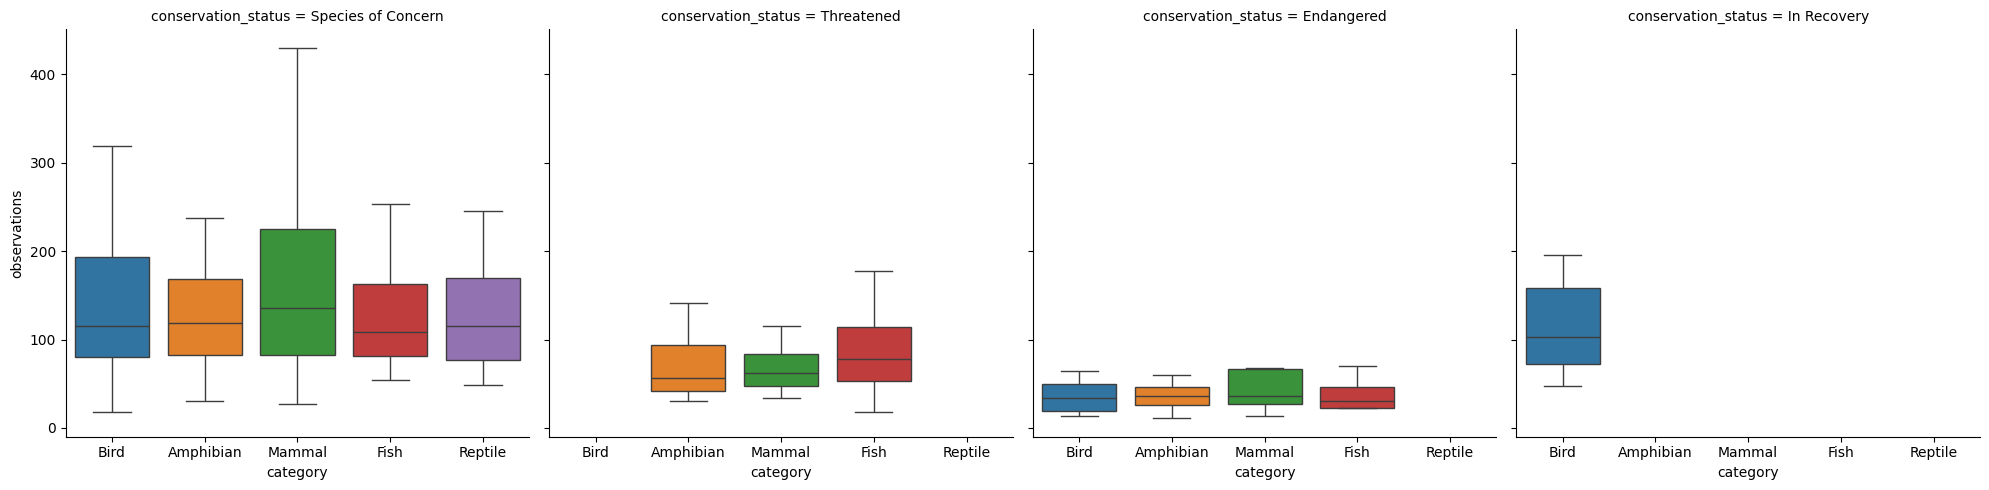

In [49]:
observation_mean_status = biodiv_conservation_animals.groupby('conservation_status',as_index=False)['observations'].mean()
print(observation_mean_status)
sns.boxplot(x='conservation_status', y='observations', data= biodiv_conservation_animals)
sns.catplot(data=biodiv_conservation_animals, col = 'conservation_status', x='category', y='observations', kind ='box', hue = 'category', showfliers = False)

#### Conclusion:
- Reprise questions and conclusions with a few key insights/applications.
    - Category is statisticall correlated with conservation status to a small to moderate degree
    - Park is strongly correlated with observations for animal species with a conservation protection status.
    - These are independent correlations, they do not interact. 
- Raise any new questions or future work
    - Interesting to investigate a more complete data set that include datetime and location of observations.
    - Interesting to investigate observations over time. 

#### Appendix:
- Technical Descriptions of unusual stats
- Detailed Tables, Computer output (not necessarily human friendly)
- Interesting or excessive figures
- Computer code used to obtain results. 